In [75]:
import os
import copy
import cv2
import random
import shutil
import torch
import torchvision
import IPython
import json

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A

from albumentations.pytorch import ToTensorV2
from PIL import Image
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
from torchvision.models import resnet50, ResNet50_Weights
from torchmetrics.classification import BinaryAccuracy, BinaryConfusionMatrix, BinaryPrecision, BinaryRecall, BinaryF1Score
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange
from math import ceil
from glob import glob

%matplotlib inline

In [2]:
CLOUD_DUMP_PATH = 'data/cloud_dump/'
CLOUD_DUMP_TOUCHED_PATH = 'data/cloud_dump/is_touched_20221006_1815.csv'
ROBOT_DUMP_PATH = 'data/robot_dump/'
CONTENT = 'data/meda_content'

In [3]:
device = torch.device('cuda:6') if torch.cuda.is_available() else torch.device('cpu')

----

##### Preprocess

In [4]:
def get_cloud_data(path):
    dfs = []
    json_paths = [path for path in [x for x in os.walk(path)][0][2] if '.json' in path]
    for name in json_paths:
        with open(os.path.join(path, name)) as f:
            dfs.append(pd.read_json(f).set_index('id'))
    return pd.concat(dfs, axis=0)
    
def get_robot_data(path):
    dfs = []
    json_paths = [path for path in [x for x in os.walk(path)][0][2] if '.json' in path]
    for name in json_paths:
        with open(os.path.join(path, name)) as f:
            dfs.append(pd.DataFrame.from_dict(json.load(f)['data']).set_index('id'))
    return pd.concat(dfs, axis=0)

def merge_data(cloud_data, robot_data, columns=['palletPlaceImageUri', 'scanResult', 'location', 'addDate']):
    assert(set(columns).issubset(cloud_data.columns))
    assert(set(columns).issubset(robot_data.columns))
    to_concat = [cloud_data[columns], robot_data[columns]]
    return pd.concat(to_concat, axis=0)

def get_raw_data(cloud_data_path, robot_data_path):
    cloud_data = get_cloud_data(cloud_data_path)
    robot_data = get_robot_data(robot_data_path)
    robot_data.rename(columns={'createdDatetime': 'addDate'}, inplace=True)
    return merge_data(cloud_data, robot_data)

In [5]:
def get_jpeg_paths(content_folder):
    jpeg_paths = {}
    for folder in os.walk(content_folder):
        for path in folder[2]:
            if '.jpeg' in path:
                jpeg_paths[path] = os.path.join(folder[0], path)
    return jpeg_paths

def replace_jpeg_paths(data, jpeg_paths, column='jpeg_path'):
    assert(column in data.columns)
    data[column] = data.apply(lambda x: jpeg_paths[x[column]] if x[column] in jpeg_paths else np.NaN, axis=1)
    return data

def preprocess(raw_data, touched_data, content_folder):
    raw_data.rename(columns={
        'palletPlaceImageUri': 'jpeg_path',
        'scanResult': 'pallet',
    }, inplace=True)
    jpeg_paths = get_jpeg_paths(content_folder)
    data = pd.merge(raw_data, touched_data, how='left',on=['pallet','location'])
    data = replace_jpeg_paths(data, jpeg_paths)
    return data

In [6]:
raw_data = get_raw_data(CLOUD_DUMP_PATH, ROBOT_DUMP_PATH)
touched_data = pd.read_csv(CLOUD_DUMP_TOUCHED_PATH, names=['pallet','location','is_touched'])

In [7]:
data = preprocess(raw_data, touched_data, CONTENT)

In [8]:
data.head()

,jpeg_path,pallet,location,addDate,is_touched
0,data/meda_content/0c80/0c809b1b-fc8a-4d79-8dfc...,PLT11285411,K22-51C5,2022-09-30T12:47:07.444998Z,NaN
1,data/meda_content/5979/59794dfa-3a9f-4e24-b2d7...,PLT11247433,K19-51C6,2022-09-30T12:46:46.170766Z,False
2,data/meda_content/b618/b6181846-5448-40c9-bb1e...,PLT11247210,K19-51B6,2022-09-30T12:46:46.055292Z,False
3,data/meda_content/a154/a1544709-148f-451d-996f...,PLT11246883,K19-51B5,2022-09-30T12:46:45.893924Z,False
4,data/meda_content/2023/2023cc38-4905-4dc5-8d11...,PLT11388400,K19-46C3,2022-09-30T12:46:45.451549Z,False


In [9]:
data = data.dropna()

In [10]:
data['is_touched'] = 1 - data['is_touched']
data['is_touched'] = data['is_touched'].astype(int)

In [11]:
data.head()

,jpeg_path,pallet,location,addDate,is_touched
1,data/meda_content/5979/59794dfa-3a9f-4e24-b2d7...,PLT11247433,K19-51C6,2022-09-30T12:46:46.170766Z,1
2,data/meda_content/b618/b6181846-5448-40c9-bb1e...,PLT11247210,K19-51B6,2022-09-30T12:46:46.055292Z,1
3,data/meda_content/a154/a1544709-148f-451d-996f...,PLT11246883,K19-51B5,2022-09-30T12:46:45.893924Z,1
4,data/meda_content/2023/2023cc38-4905-4dc5-8d11...,PLT11388400,K19-46C3,2022-09-30T12:46:45.451549Z,1
5,data/meda_content/e404/e404e452-9121-4036-b5e3...,PLT11244225,K19-51B4,2022-09-30T12:46:45.387256Z,1


In [12]:
data_train, data_test = train_test_split(data, test_size=0.33, random_state=42)

----

#### Data analysis

<AxesSubplot:>

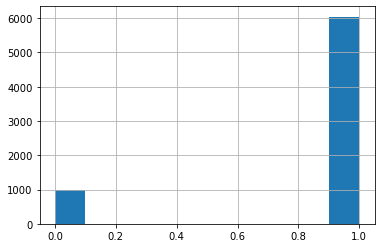

In [13]:
data['is_touched'].hist()

In [14]:
def print_img(path):
    image = cv2.imread(path)
    fig, ax = plt.subplots()

    ax.imshow(image)
    ax.set_title(type(image))

    fig.set_figwidth(10)
    fig.set_figheight(10)

    plt.show()

def get_example_data(data, is_touched, n=5):
    need_data = data[data['is_touched'] != is_touched]

    for it, (idx, row) in enumerate(need_data.iterrows()):
        print_img(row['jpeg_path'])
        if it == 5:
            break

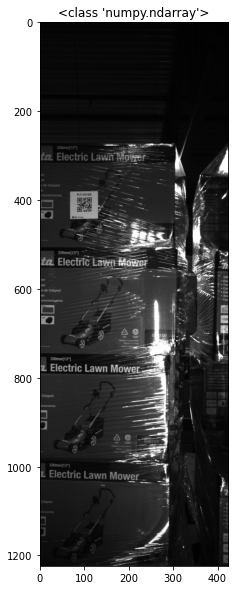

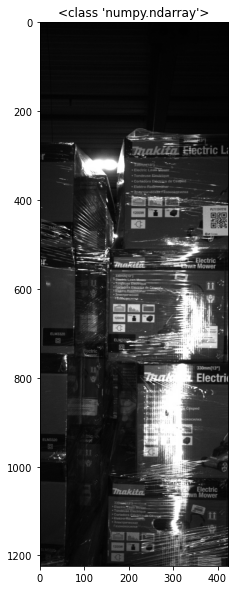

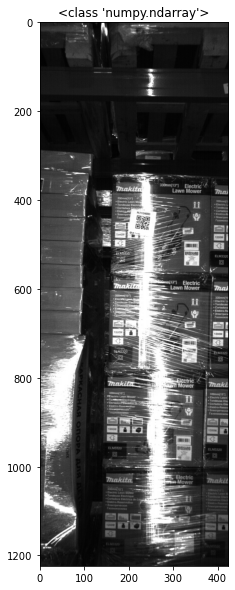

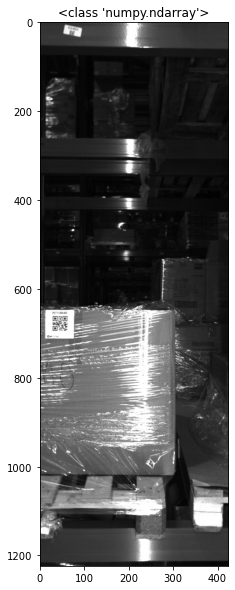

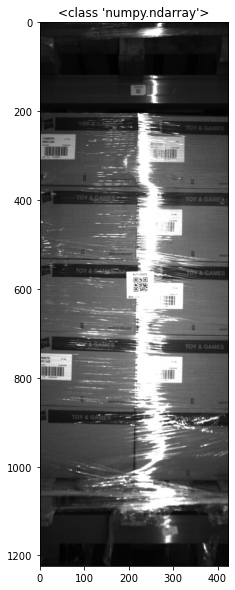

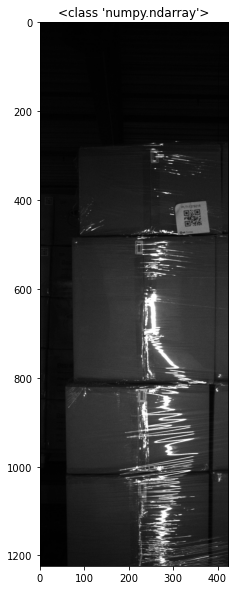

In [15]:
get_example_data(data, False)

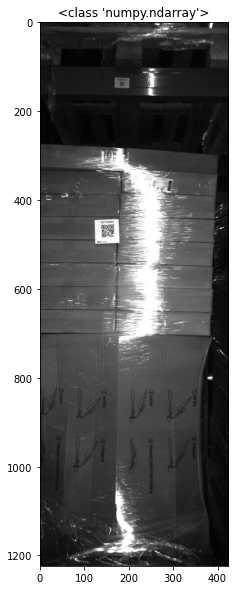

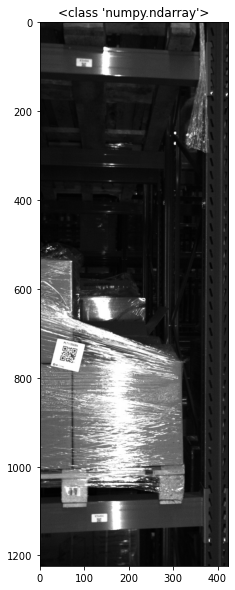

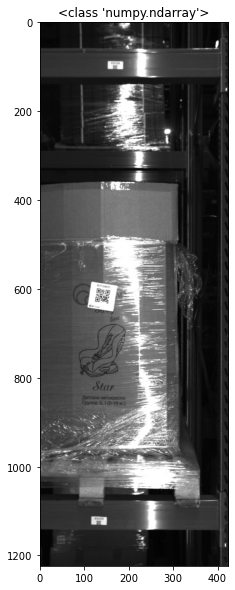

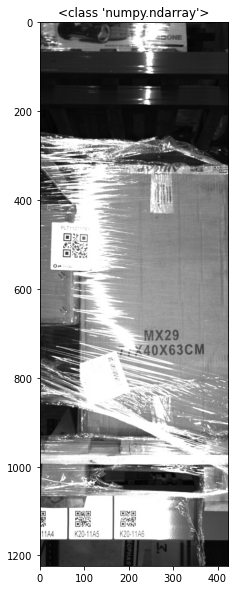

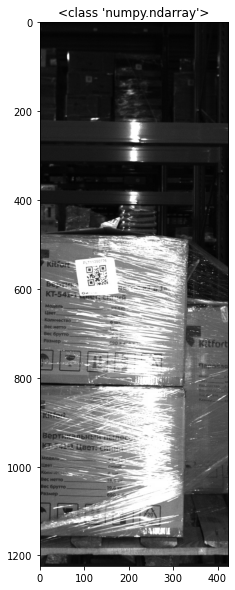

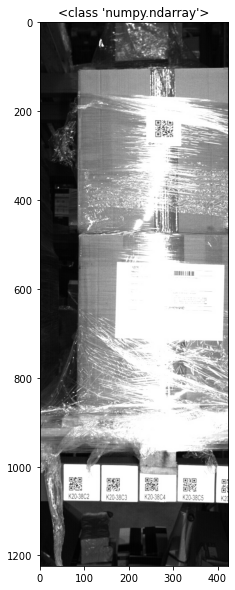

In [16]:
get_example_data(data, True)
        

ну ок.

----

#### Data Helpers

In [17]:
class PackageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):        
        img_jpeg_path = self.dataset.iloc[idx]['jpeg_path']
        is_touched = self.dataset.iloc[idx]['is_touched']
        
        image = np.array(Image.open(img_jpeg_path))
        
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return {'image': image, 'target': is_touched}

In [25]:
test_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
        A.Resize(width=208, height=608),
        ToTensorV2()
    ]
)

train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Resize(width=208, height=608),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [26]:
train_dataset = PackageDataset(data_train, train_transform)

test_dataset = PackageDataset(data_test, test_transform)

In [27]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True,
    batch_size=16, num_workers=8
)

val_dataloader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False,
    batch_size=16, num_workers=8
)

In [28]:
def visualize_augmentations(dataset, idx=500, samples=3):
    """The function visualizes an augmented image"""
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=1, figsize=(24, 48))
    for i in range(samples):
        image, is_touched = dataset[idx]['image'], dataset[idx]['target']
        ax[i].imshow(image)
        ax[i].set_title(f"Augmented image, is_touched = {bool(not is_touched)}")
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

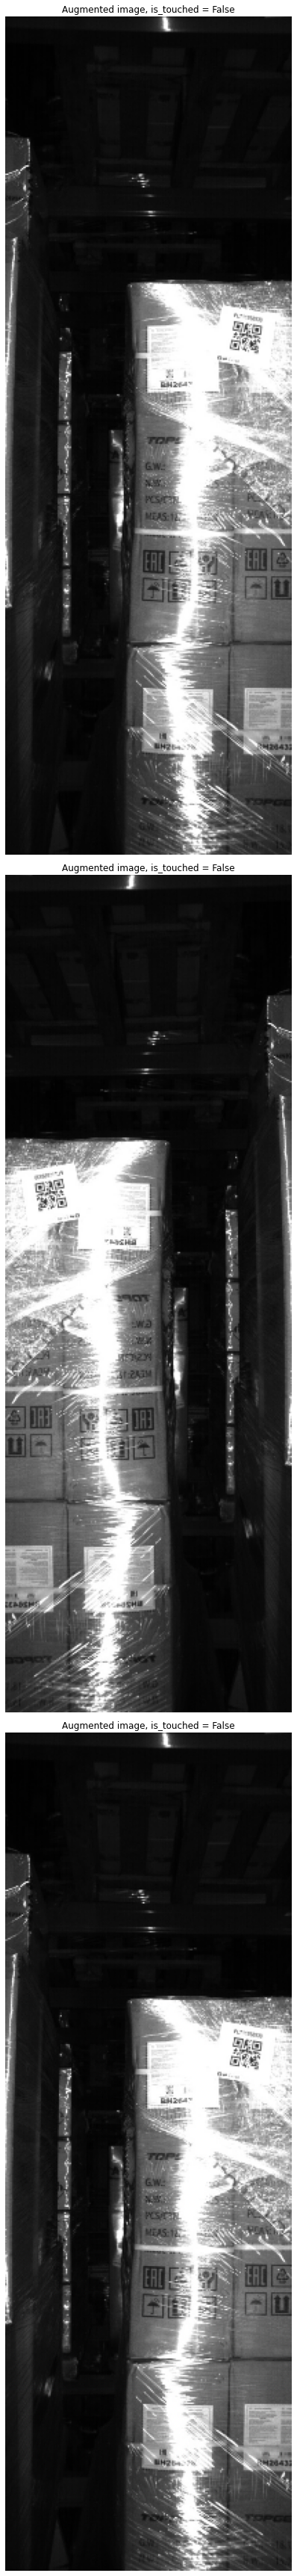

In [29]:
visualize_augmentations(train_dataset, idx=3)

----

#### Learn Helpers

In [58]:
def train_loop(model, train_loader, criterion, optimizer):
    train_loss = num_samples = 0.0
    sigmoid = nn.Sigmoid()
    for batch in tqdm(train_loader):
        batch_pred = model(batch['image'].to(device))
        batch_pred = batch_pred.squeeze(-1)
        loss = criterion(sigmoid(batch_pred), batch['target'].to(device).float())

        num_samples += len(batch_pred)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
            
    train_loss = train_loss / num_samples
    return model, optimizer, train_loss

In [57]:
def test_loop(model, val_loader, criterion, metrics):
    sigmoid = nn.Sigmoid()
    with torch.no_grad():
        logs_num = 0
        val_losses = 0.0
        accuracy = []
        precision = []
        recall = []
        f1_score = []
        confusion_matrix = torch.zeros((2, 2))
        
        for batch in tqdm(val_loader):
            preds = model(batch['image'].to(device))
            preds = preds.squeeze(-1)
            target = batch['target'].to(device)

            # compute loss
            #
            loss = criterion(sigmoid(preds), batch['target'].to(device).float())
            val_losses += loss.item()

            # compute metrics
            #
            accuracy.append(metrics['accuracy'](preds, target).cpu())
            precision.append(metrics['precision'](preds, target).cpu())
            recall.append(metrics['recall'](preds, target).cpu())
            f1_score.append(metrics['f1_score'](preds, target).cpu())
            confusion_matrix += metrics['confusion_matrix'](preds, target).cpu()

            logs_num += len(target)

    return val_losses / logs_num, np.mean(accuracy), np.mean(precision), np.mean(recall), np.mean(f1_score), confusion_matrix

In [72]:
def learning_loop(model, optimizer, train_loader, val_loader, 
                loss_fn, metrics, epochs=10):

    plot_result = {
        'train_loss': [], 
        'test_loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'confusion_matrix': []
    }

    best_recall = float('inf')
    best_model = None

    for epoch in range(1, epochs+1):
        # train
        #
        print(f'#{epoch}/{epochs}:')
        model, optimizer, train_loss = train_loop(model, train_loader, loss_fn, optimizer)
        plot_result['train_loss'].append(train_loss)

        # test
        #
        test_losses, accuracy, precision, recall, f1_score, confusion_matrix = test_loop(model, val_loader, loss_fn, metrics)
        plot_result['test_loss'].append(test_losses)
        plot_result['accuracy'] += [accuracy]
        plot_result['precision'] += [precision]
        plot_result['recall'] += [recall]
        plot_result['f1_score'] += [f1_score]
        plot_result['confusion_matrix'] += [confusion_matrix]


        if recall < best_recall:
            best_recall = recall
            best_model = copy.deepcopy(model)

        # plot
        #
        clear_output(True)
       
        fig = make_subplots(rows=3, cols=2)

        for idx, (key, value) in enumerate(plot_result.items()):

            if key == 'confusion_matrix':
                print('Confusion Matrix:')
                for matrix in value:
                    cnfs_mtrx = '''
                    TP = {0}; FN = {1}
                    FP = {2}; TN = {3}
                    '''
                    cnfs_mtrx = cnfs_mtrx.format(matrix[0, 0], matrix[0, 1], matrix[1, 0], matrix[1, 1])
                    print(cnfs_mtrx)
                continue

            fig.add_trace(
                go.Scatter(y=value, name=key),
                row=idx // 2 + 1, col= idx % 2 + 1
            )

        fig.update_layout(height=600, width=800, title_text=f'#{epoch}/{epochs}:')
        fig.show()
    
    return model, optimizer, plot_result

In [73]:
def create_model_and_optimizer(net, lr=1e-4, beta1=0.9, beta2=0.999, device=device):
    model = net.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr, [beta1, beta2])
    return model, optimizer

----

#### Train

In [76]:
metrics = {
    'accuracy': BinaryAccuracy().to(device),
    'precision': BinaryPrecision().to(device),
    'recall': BinaryRecall().to(device),
    'f1_score': BinaryF1Score().to(device),
    'confusion_matrix': BinaryConfusionMatrix().to(device)
}
loss_fn = nn.BCELoss()

resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

resnet, optimizer_resnet = create_model_and_optimizer(resnet)

In [77]:
resnet, optimizer_resnet, plot_result = learning_loop(
    model=resnet,
    optimizer=optimizer_resnet,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    loss_fn=loss_fn,
    metrics=metrics,
    epochs=10
)

Confusion Matrix:

                    TP = 69.0; FN = 265.0
                    FP = 0.0; TN = 1988.0
                    

                    TP = 235.0; FN = 99.0
                    FP = 26.0; TN = 1962.0
                    

                    TP = 303.0; FN = 31.0
                    FP = 44.0; TN = 1944.0
                    

                    TP = 284.0; FN = 50.0
                    FP = 8.0; TN = 1980.0
                    

                    TP = 313.0; FN = 21.0
                    FP = 33.0; TN = 1955.0
                    

                    TP = 264.0; FN = 70.0
                    FP = 3.0; TN = 1985.0
                    

                    TP = 305.0; FN = 29.0
                    FP = 8.0; TN = 1980.0
                    

                    TP = 307.0; FN = 27.0
                    FP = 19.0; TN = 1969.0
                    

                    TP = 305.0; FN = 29.0
                    FP = 16.0; TN = 1972.0
                    

                    TP

----

#### Анализ результата

In [65]:
len(data_test[data_test['is_touched'] == 0])

334

In [66]:
len(data_test[data_test['is_touched'] == 1])

1988

In [133]:
def get_fp_and_fn(model, val_loader):
    sigmoid = nn.Sigmoid()
    with torch.no_grad():
        preds = []
        targets = []
        
        for batch in tqdm(val_dataloader):
            pred = resnet(batch['image'].to(device))
            pred = sigmoid(pred.squeeze(-1)).cpu().numpy()
            target = batch['target'].numpy()

            preds = np.concatenate([preds, pred])
            targets = np.concatenate([targets, target])
        
    preds = [1. if pred > 0.5 else 0 for pred in preds]

    false_positive = [True if (pred == 0 and pred != target) else False 
                        for pred, target in zip(preds, targets)]

    false_negtive = [True if (pred == 1 and pred != target) else False 
                        for pred, target in zip(preds, targets)]
    return [i for i, x in enumerate(false_negative) if x], [i for i, x in enumerate(false_positive) if x]


def plot_sample(idxs, data, n=5, name_sample=None):
    n = n if len(idxs) > n else len(idxs)
    if name_sample:
        print(name_sample)

    sample_idxs = np.random.choice(idxs, size=n, replace=False)
    for idx in sample_idxs:
        print_img(data.iloc[idx]['jpeg_path'])

In [118]:
fn_idxs, fp_idxs = get_fp_and_fn(resnet, val_dataloader)

  0%|          | 0/146 [00:00<?, ?it/s]

False Negative


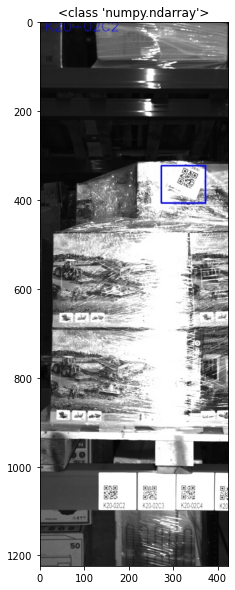

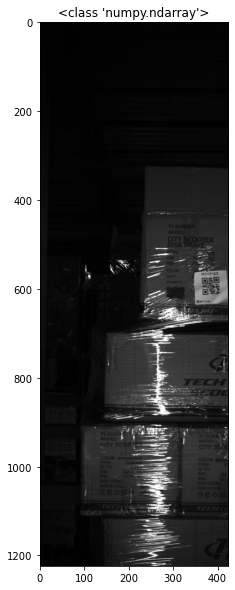

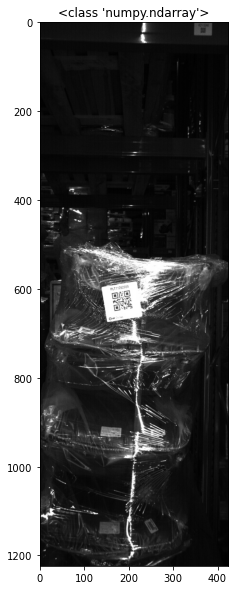

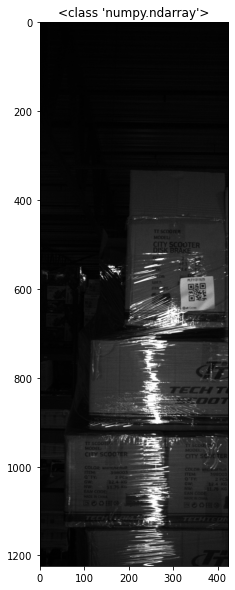

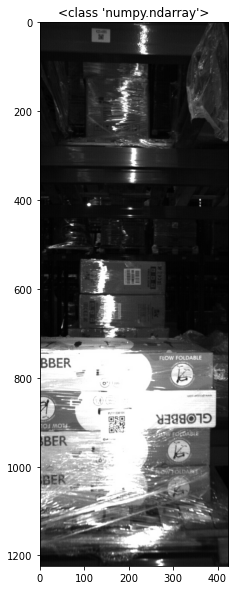

In [134]:
plot_sample(fn_idxs, data_test, name_sample='False Negative')

False Positive


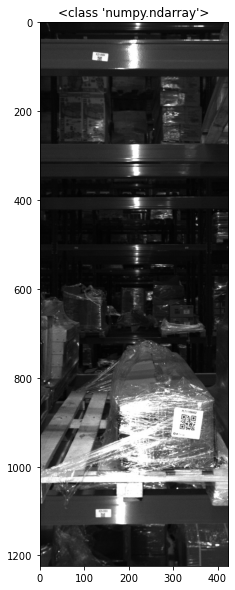

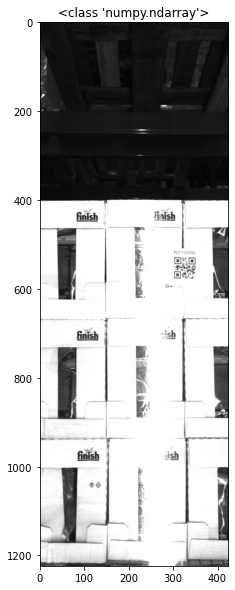

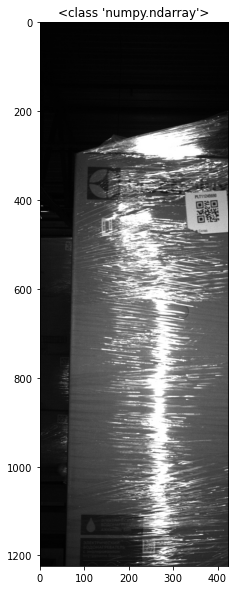

In [135]:
plot_sample(fp_idxs, data_test, name_sample='False Positive')